In [2]:
import torch
import torch.nn.functional as F

device = torch.device("cpu")

# 1. 모델 구조 재정의
class MultiLabelBert(torch.nn.Module):
    def __init__(self, model, num_emotions=6, num_classes=5):
        super().__init__()
        self.bert = model.bert  # BERT의 기본 구조 재사용
        self.classifiers = torch.nn.ModuleList([
            torch.nn.Linear(model.config.hidden_size, num_classes) for _ in range(num_emotions)
        ])
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        logits = [classifier(outputs.pooler_output) for classifier in self.classifiers]
        logits = torch.stack(logits, dim=1)  # (batch_size, num_emotions, num_classes)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = sum(loss_fct(logits[:, i, :], labels[:, i]) for i in range(labels.size(1)))
        return (loss, logits) if loss is not None else logits

# 2. 모델 로드
from transformers import BertForSequenceClassification
pretrained_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=30)
multi_label_model = MultiLabelBert(pretrained_model)

# 3. 저장된 가중치 불러오기
state_dict = torch.load("./model/bert-classification.pt", map_location=torch.device('cpu'))
multi_label_model.load_state_dict(state_dict)
multi_label_model.to(device)

# 4. 평가 모드로 전환 (필수)
multi_label_model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/ld/ssbrz8sd4rdfbzqjq4zjrfq80000gn/T/ipykernel_2149/1362144393.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

MultiLabelBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [30]:
def answer_from_bert(diary_entry):
    input_data = tokenizer(diary_entry, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    # 모델 예측
    with torch.no_grad():
        output = multi_label_model(input_data["input_ids"], attention_mask=input_data["attention_mask"])
        logits = output if isinstance(output, torch.Tensor) else output[1]  # loss 없는 경우 처리
        predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

    emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]
    result = {emotion: pred + 1 for emotion, pred in zip(emotions, predictions)}  # 0~4 -> 1~5
    return result

diary="""
I felt like I was soaring, bursting with joy so intense it almost hurt—but then, out of nowhere, it was ripped away, leaving me drowning in a pit of despair so dark I couldn’t breathe. It’s like my heart is being torn in two—one half screaming with happiness, the other crumbling under the weight of unbearable pain.
"""
res = answer_from_bert(diary_entry)
print(res)

{'joy': 1, 'sadness': 3, 'anger': 2, 'fear': 2, 'disgust': 2, 'surprise': 1}


# Compare New Test Data - Chat GPT vs BERT

In [ ]:
import os
import re
import json
os.environ["OPENAI_API_KEY"] = "#####"

from openai import OpenAI
client = OpenAI()

def get_json(content):
    #get json part
    json_text = re.search(r'\{.*\}', content, re.DOTALL)
    # check json data
    if json_text:
        myjson = json_text.group()
        #print("Extracted JSON:", myjson)  # check extracted json
        try:
            data = json.loads(myjson)  # JSON parsing
            return data
        except json.JSONDecodeError as e:
            print("[jp] JSON parsing error:", e)
    else:
        print("[jp] JSON data not found")
    
    
    

def answer_from_gpt(system_content,diary):
    user_content= f"Diary_entry=\"{diary}\""
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": system_content
            },
            {
                "role": "user",
                "content": user_content
            }
        ]
    )

    answer = response.choices[0].message.content #get json response
    return get_json(answer)

system_content = """
You will analyze the diary entry based on the 6 core emotions in psychology: joy, sadness, anger, fear, disgust, surprise. Each emotion's intensity will be rated on a scale of 1 to 5 as follows:
1 - very weak (barely felt)
2 - weak (slightly felt)
3 - moderate (moderately felt)
4 - strong (strongly felt)
5 - very strong (very strongly felt)
Please respond strictly in JSON format with the following structure:

{
  "joy": ...,
  "sadness": ...,
  "anger": ...,
  "fear": ...,
  "disgust": ...,
  "surprise": ...
}
"""


diary="""
I felt like I was soaring, bursting with joy so intense it almost hurt—but then, out of nowhere, it was ripped away, leaving me drowning in a pit of despair so dark I couldn’t breathe. It’s like my heart is being torn in two—one half screaming with happiness, the other crumbling under the weight of unbearable pain.
"""

json_result = answer_from_gpt(system_content,diary)
print(json_result)

{'joy': 5, 'sadness': 5, 'anger': 3, 'fear': 4, 'disgust': 2, 'surprise': 4}


In [21]:
import pandas as pd

# 파일 경로 지정
file_path = 'test-created-164-answer-created-int.csv'

# CSV 파일 불러오기
df = pd.read_csv(file_path)
print(df.columns)

Index(['Unnamed: 0', 'diary_entry', 'joy', 'sadness', 'anger', 'fear',
       'disgust', 'surprise'],
      dtype='object')


In [25]:
import pandas as pd

# 파일 경로 지정
file_path = 'test164.csv'

# CSV 파일 불러오기
df = pd.read_csv(file_path)

#df파일에서 diary_entry와 joy, sadness, anger,fear, disgust,surprise값을 읽어온다


#sample
diary_entry = """
I heard Moana 2 has been released. I loved the songs in the first movie, but I got spoiled by the Moana 2 playlist on Spotify—ugh! I think the songs from the first movie were better. Should I go watch the movie or not?
"""

def getmodelresult(diary_entry):
    input_data = tokenizer(diary_entry, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # 모델 예측
    with torch.no_grad():
        output = multi_label_model(input_data["input_ids"], attention_mask=input_data["attention_mask"])
        logits = output if isinstance(output, torch.Tensor) else output[1]  # loss 없는 경우 처리
        predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

    # 결과 해석
    emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]
    result = {emotion: pred + 1 for emotion, pred in zip(emotions, predictions)}  # 0~4 -> 1~5
    return result

result = getmodelresult(diary_entry)

#result is in json format string, load it in json format and compare with the answer in data


#for each diary content evaluate mae, mse, rmse, pearson, for the two different answer

In [15]:
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

# 파일 경로 지정
file_path = 'test164.csv'

# CSV 파일 불러오기
df = pd.read_csv(file_path)

# 모델 결과를 얻기 위한 함수 정의
def getmodelresult(diary_entry):
    input_data = tokenizer(diary_entry, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # 모델 예측
    with torch.no_grad():
        output = multi_label_model(input_data["input_ids"], attention_mask=input_data["attention_mask"])
        logits = output if isinstance(output, torch.Tensor) else output[1]  # loss 없는 경우 처리
        predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

    # 결과 해석
    emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]
    result = {emotion: pred + 1 for emotion, pred in zip(emotions, predictions)}  # 0~4 -> 1~5
    return result

# 각 감정별 평가 결과 저장
emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]
results = {emotion: {"mae": [], "mse": [], "rmse": [], "pearson": []} for emotion in emotions}

for idx, row in df.iterrows():
    diary_entry = row['diary_entry']
    true_values = [row[emotion] for emotion in emotions]
    
    # 모델 결과 얻기
    predicted_values = list(getmodelresult(diary_entry).values())
    
    for i, emotion in enumerate(emotions):
        true = true_values[i]
        pred = predicted_values[i]
        
        # MAE, MSE 저장
        mae = abs(true - pred)
        mse = (true - pred) ** 2
        results[emotion]["mae"].append(mae)
        results[emotion]["mse"].append(mse)
        
        # Pearson 상관계수는 모든 데이터가 쌓인 후 계산
        results[emotion]["pearson"].append((true, pred))

# 각 감정별 RMSE, MAE, MSE, Pearson 계산
for emotion in emotions:
    mae_avg = np.mean(results[emotion]["mae"])
    mse_avg = np.mean(results[emotion]["mse"])
    rmse_avg = np.sqrt(mse_avg)
    
    # Pearson 상관계수 계산
    true_vals, pred_vals = zip(*results[emotion]["pearson"])
    pearson_corr, _ = pearsonr(true_vals, pred_vals)
    
    # 결과 출력
    print(f"Emotion: {emotion}")
    print(f"  MAE: {mae_avg:.4f}")
    print(f"  MSE: {mse_avg:.4f}")
    print(f"  RMSE: {rmse_avg:.4f}")
    print(f"  Pearson Correlation: {pearson_corr:.4f}")
    print("-" * 30)

Emotion: joy
  MAE: 0.5767
  MSE: 0.8098
  RMSE: 0.8999
  Pearson Correlation: 0.8083
------------------------------
Emotion: sadness
  MAE: 0.3865
  MSE: 0.5092
  RMSE: 0.7136
  Pearson Correlation: 0.6688
------------------------------
Emotion: anger
  MAE: 0.2086
  MSE: 0.2699
  RMSE: 0.5196
  Pearson Correlation: 0.6497
------------------------------
Emotion: fear
  MAE: 0.4969
  MSE: 0.6196
  RMSE: 0.7872
  Pearson Correlation: 0.4641
------------------------------
Emotion: disgust
  MAE: 0.1840
  MSE: 0.1963
  RMSE: 0.4431
  Pearson Correlation: 0.5493
------------------------------
Emotion: surprise
  MAE: 0.6810
  MSE: 0.8773
  RMSE: 0.9366
  Pearson Correlation: 0.4263
------------------------------


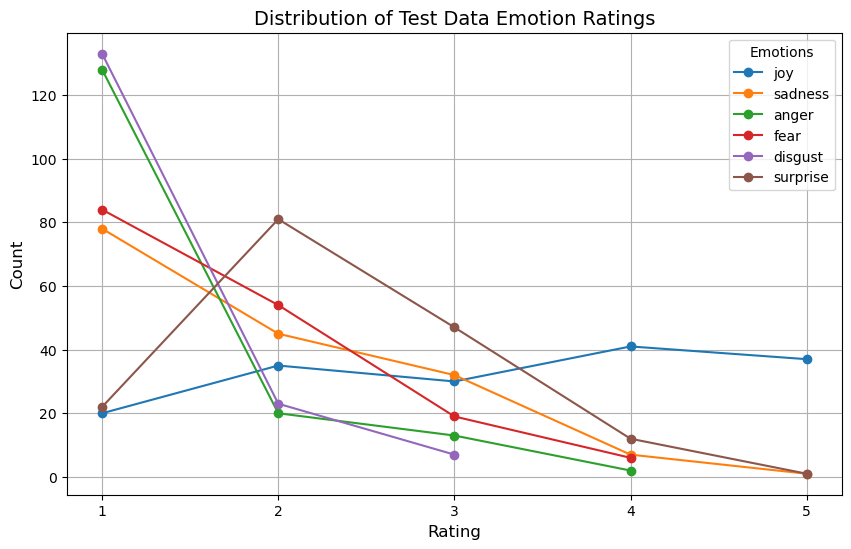

In [20]:
import matplotlib.pyplot as plt

# 감정별 데이터 분포 계산
emotion_distribution = {emotion: df[emotion].value_counts().sort_index() for emotion in emotions}

# 꺾은선 그래프 데이터 준비
ratings = range(1, 6)  # 점수 범위: 1~5
plt.figure(figsize=(10, 6))

# 각 감정의 데이터 추가
for emotion, counts in emotion_distribution.items():
    plt.plot(
        counts.index,  # 점수 (1~5)
        counts.values,  # 해당 점수의 개수
        marker='o',
        label=emotion
    )

# 그래프 꾸미기
plt.title("Distribution of Test Data Emotion Ratings", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ratings)  # X축 눈금 설정
plt.legend(title="Emotions")
plt.grid(True)
plt.show()

# Test with negatives

In [22]:
# import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

# 파일 경로 지정
file_path = 'negative164.csv'

# CSV 파일 불러오기
df = pd.read_csv(file_path)

# 모델 결과를 얻기 위한 함수 정의
def getmodelresult(diary_entry):
    input_data = tokenizer(diary_entry, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # 모델 예측
    with torch.no_grad():
        output = multi_label_model(input_data["input_ids"], attention_mask=input_data["attention_mask"])
        logits = output if isinstance(output, torch.Tensor) else output[1]  # loss 없는 경우 처리
        predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

    # 결과 해석
    emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]
    result = {emotion: pred + 1 for emotion, pred in zip(emotions, predictions)}  # 0~4 -> 1~5
    return result

# 각 감정별 평가 결과 저장
emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]
results = {emotion: {"mae": [], "mse": [], "rmse": [], "pearson": []} for emotion in emotions}

for idx, row in df.iterrows():
    diary_entry = row['negative_diary_entry']
    true_values = [row[emotion] for emotion in emotions]
    
    # 모델 결과 얻기
    predicted_values = list(getmodelresult(diary_entry).values())
    
    for i, emotion in enumerate(emotions):
        true = true_values[i]
        pred = predicted_values[i]
        
        # MAE, MSE 저장
        mae = abs(true - pred)
        mse = (true - pred) ** 2
        results[emotion]["mae"].append(mae)
        results[emotion]["mse"].append(mse)
        
        # Pearson 상관계수는 모든 데이터가 쌓인 후 계산
        results[emotion]["pearson"].append((true, pred))

# 각 감정별 RMSE, MAE, MSE, Pearson 계산
for emotion in emotions:
    mae_avg = np.mean(results[emotion]["mae"])
    mse_avg = np.mean(results[emotion]["mse"])
    rmse_avg = np.sqrt(mse_avg)
    
    # Pearson 상관계수 계산
    true_vals, pred_vals = zip(*results[emotion]["pearson"])
    pearson_corr, _ = pearsonr(true_vals, pred_vals)
    
    # 결과 출력
    print(f"Emotion: {emotion}")
    print(f"  MAE: {mae_avg:.4f}")
    print(f"  MSE: {mse_avg:.4f}")
    print(f"  RMSE: {rmse_avg:.4f}")
    print(f"  Pearson Correlation: {pearson_corr:.4f}")
    print("-" * 30)

Emotion: joy
  MAE: 0.1350
  MSE: 0.2209
  RMSE: 0.4700
  Pearson Correlation: -0.0377
------------------------------
Emotion: sadness
  MAE: 0.7178
  MSE: 0.9264
  RMSE: 0.9625
  Pearson Correlation: 0.1856
------------------------------
Emotion: anger
  MAE: 0.7546
  MSE: 1.1472
  RMSE: 1.0711
  Pearson Correlation: 0.3324
------------------------------
Emotion: fear
  MAE: 0.9632
  MSE: 1.6626
  RMSE: 1.2894
  Pearson Correlation: 0.1811
------------------------------
Emotion: disgust
  MAE: 0.7914
  MSE: 1.2086
  RMSE: 1.0994
  Pearson Correlation: 0.1342
------------------------------
Emotion: surprise
  MAE: 0.4969
  MSE: 0.5828
  RMSE: 0.7634
  Pearson Correlation: 0.3913
------------------------------


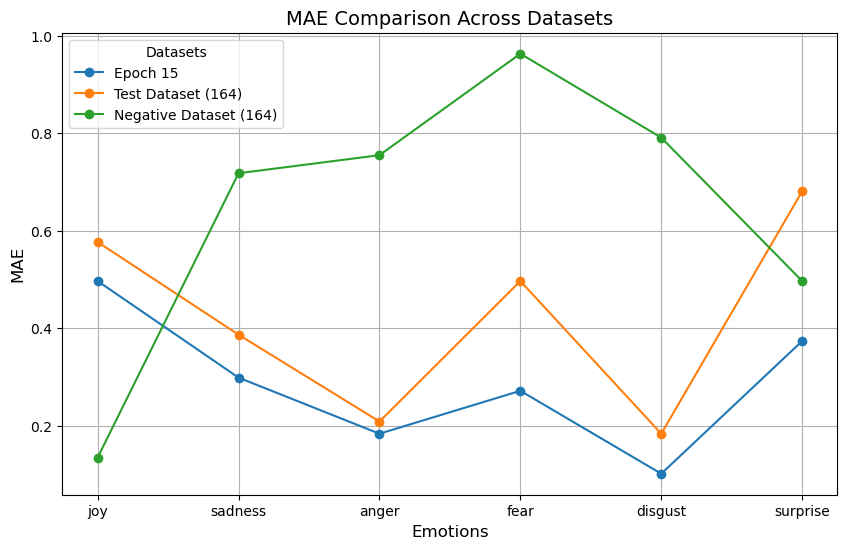

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]

# 세 가지 데이터셋의 MAE 값
mae_epoch15 = [0.497, 0.299, 0.184, 0.272, 0.102, 0.374]
mae_test164 = [0.577, 0.387, 0.209, 0.497, 0.184, 0.681]
mae_negative164 = [0.135, 0.718, 0.755, 0.963, 0.791, 0.497]

# X축 범위 설정
x = np.arange(len(emotions))

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x, mae_epoch15, marker='o', label="Epoch 15")
plt.plot(x, mae_test164, marker='o', label="Test Dataset (164)")
plt.plot(x, mae_negative164, marker='o', label="Negative Dataset (164)")

# 그래프 꾸미기
plt.title("MAE Comparison Across Datasets", fontsize=14)
plt.xlabel("Emotions", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.xticks(x, emotions)  # X축 눈금에 감정 이름 표시
plt.legend(title="Datasets", fontsize=10)
plt.grid(True)
plt.show()

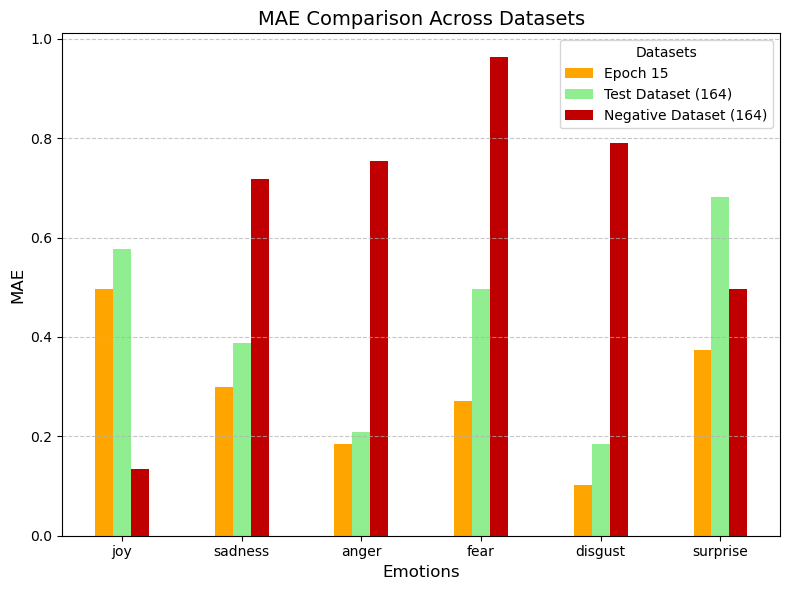

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise"]

# 세 가지 데이터셋의 MAE 값
mae_epoch15 = [0.497, 0.299, 0.184, 0.272, 0.102, 0.374]
mae_test164 = [0.577, 0.387, 0.209, 0.497, 0.184, 0.681]
mae_negative164 = [0.135, 0.718, 0.755, 0.963, 0.791, 0.497]

# X축 범위와 막대 폭 설정
x = np.arange(len(emotions))
bar_width = 0.15

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width, mae_epoch15, width=bar_width, color="orange", label="Epoch 15")
plt.bar(x, mae_test164, width=bar_width, color="lightgreen", label="Test Dataset (164)")
plt.bar(x + bar_width, mae_negative164, width=bar_width, color="#C00000", label="Negative Dataset (164)")

# 그래프 꾸미기
plt.title("MAE Comparison Across Datasets", fontsize=14)
plt.xlabel("Emotions", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.xticks(x, emotions)  # X축 눈금에 감정 이름 표시
plt.legend(title="Datasets", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 그래프 출력
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 각 감정별 평가 결과 저장
results_binary = {emotion: {"accuracy": [], "precision": [], "recall": [], "f1": []} for emotion in emotions}

for idx, row in df.iterrows():
    diary_entry = row['negative_diary_entry']
    true_values = [row[emotion] for emotion in emotions]
    
    # 모델 결과 얻기
    predicted_values = list(getmodelresult(diary_entry).values())
    
    for i, emotion in enumerate(emotions):
        true = true_values[i]
        pred = predicted_values[i]
        
        # 감정을 2 이하: "감정 없음"(0), 3 이상: "감정 있음"(1)으로 변환
        true_binary = 1 if true >= 3 else 0
        pred_binary = 1 if pred >= 3 else 0
        
        # 각 감정에 대해 예측 및 참값 저장
        results_binary[emotion]["accuracy"].append(true_binary == pred_binary)
        results_binary[emotion]["precision"].append((true_binary, pred_binary))
        results_binary[emotion]["recall"].append((true_binary, pred_binary))
        results_binary[emotion]["f1"].append((true_binary, pred_binary))

# 최종 지표 계산
for emotion in emotions:
    true_vals = [t for t, _ in results_binary[emotion]["precision"]]
    pred_vals = [p for _, p in results_binary[emotion]["precision"]]
    
    accuracy = accuracy_score(true_vals, pred_vals)
    precision = precision_score(true_vals, pred_vals, zero_division=0)
    recall = recall_score(true_vals, pred_vals, zero_division=0)
    f1 = f1_score(true_vals, pred_vals, zero_division=0)
    
    # 결과 출력
    print(f"Emotion: {emotion}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print("-" * 30)


Emotion: joy
  Accuracy: 0.9816
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
------------------------------
Emotion: sadness
  Accuracy: 0.8344
  Precision: 0.8658
  Recall: 0.9485
  F1-Score: 0.9053
------------------------------
Emotion: anger
  Accuracy: 0.5276
  Precision: 0.8750
  Recall: 0.1573
  F1-Score: 0.2667
------------------------------
Emotion: fear
  Accuracy: 0.5092
  Precision: 0.6000
  Recall: 0.1429
  F1-Score: 0.2308
------------------------------
Emotion: disgust
  Accuracy: 0.4417
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
------------------------------
Emotion: surprise
  Accuracy: 0.8282
  Precision: 0.5000
  Recall: 0.1071
  F1-Score: 0.1765
------------------------------
